In [1]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import helpers
from src import dataset

In [2]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
df = dataset.load_excel(excel_file)

In [3]:
df_italy = df.iloc[:, 0:1] # Arrivals to Italy
df_greek_island = df.iloc[:, 1:2] # Arrivals to Greek Island
df_mainland_greece = df.iloc[:, 2:3] # Arrivals to Mainland greece
df_fyrom = df.iloc[:, 3:4] # Arrivals to fYRoM
df_serbia = df.iloc[:, 4:5] # Arrivals to Serbia
df_croatia = df.iloc[:, 5:6] # Arrivals to Croatia
df_hungry = df.iloc[:, 6:7] # Arrivals to Hungry
df_slovenia = df.iloc[:, 7:8] # Arrivals to Slovenia
df_austria = df.iloc[:, 8:9] # Arrivals to Austria

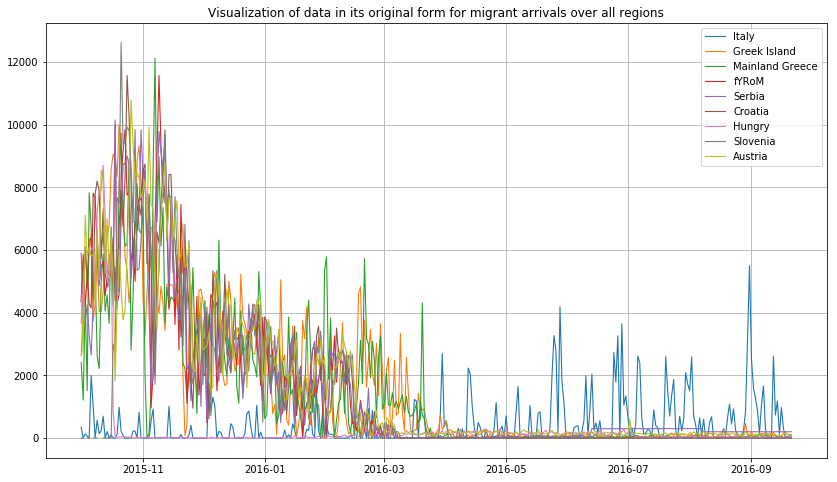

In [4]:
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals over all regions")
plt.grid(True)
plt.show()

In [4]:
df = df_italy # Seriies to test
column_name = df.columns[0]
print("Region %s will be used for the analysis" % column_name)

Region Arrivals to Italy will be used for the analysis


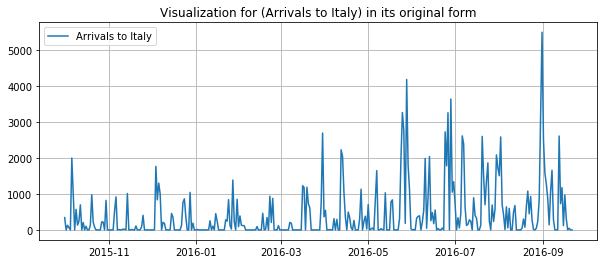

In [25]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [5]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [27]:
df_to_test.head()

,Arrivals to Italy
Date,
2015-10-01,343
2015-10-02,343
2015-10-03,128
2015-10-04,62
2015-10-05,62


In [6]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [7]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [8]:
def sarima_configs(seasonal=None):
    """Generate all possible combinations of hyperparameters
    """
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [11]:
def grid_search(series):
    results = []
    configs = sarima_configs()
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
        except:
            continue
        error = measure_rmse(series, prediction)
        result = (config, error)
        results.append(result)
        print(result)
    return results

In [12]:
results = grid_search(df_to_test)

([(0, 0, 0), (0, 0, 0, 0), 'n'], 943.9265953277018)
([(0, 0, 0), (0, 0, 1, 0), 'n'], 766.943270060691)
([(0, 0, 0), (0, 0, 2, 0), 'n'], 708.2950079310258)
([(0, 0, 0), (1, 0, 0, 0), 'n'], 661.4808601402493)
([(0, 0, 0), (1, 0, 1, 0), 'n'], 650.9171308402418)
([(0, 0, 0), (1, 0, 2, 0), 'n'], 640.4523794778431)
([(0, 0, 0), (2, 0, 0, 0), 'n'], 652.9494371182461)
([(0, 0, 0), (2, 0, 1, 0), 'n'], 621.0404422316127)
([(0, 0, 0), (2, 0, 2, 0), 'n'], 650.9622740101868)
([(0, 0, 0), (0, 0, 0, 0), 'c'], 733.1264642004305)
([(0, 0, 0), (0, 0, 1, 0), 'c'], 651.9561691052514)
([(0, 0, 0), (0, 0, 2, 0), 'c'], 631.6354685995295)
([(0, 0, 0), (1, 0, 0, 0), 'c'], 624.2268998205059)
([(0, 0, 0), (1, 0, 1, 0), 'c'], 623.2975187986476)
([(0, 0, 0), (1, 0, 2, 0), 'c'], 630.8506495903945)
([(0, 0, 0), (2, 0, 0, 0), 'c'], 623.2345903505179)
([(0, 0, 0), (2, 0, 1, 0), 'c'], 623.4968509517822)
([(0, 0, 0), (2, 0, 2, 0), 'c'], 623.3014580578617)
([(0, 0, 0), (0, 0, 0, 0), 't'], 715.1071143913487)
([(0, 0, 0), 

([(0, 1, 1), (1, 0, 2, 0), 'c'], 621.1611591875768)
([(0, 1, 1), (2, 0, 0, 0), 'c'], 619.6445743847335)
([(0, 1, 1), (2, 0, 1, 0), 'c'], 618.8084085751636)
([(0, 1, 1), (2, 0, 2, 0), 'c'], 619.1629666147466)
([(0, 1, 1), (0, 0, 0, 0), 't'], 672.7008222648359)
([(0, 1, 1), (0, 0, 1, 0), 't'], 639.2554114764579)
([(0, 1, 1), (0, 0, 2, 0), 't'], 633.5900557265887)
([(0, 1, 1), (1, 0, 0, 0), 't'], 619.9686660770188)
([(0, 1, 1), (1, 0, 1, 0), 't'], 620.3867663770804)
([(0, 1, 1), (1, 0, 2, 0), 't'], 621.1196057594847)
([(0, 1, 1), (2, 0, 0, 0), 't'], 619.7076138472188)
([(0, 1, 1), (2, 0, 1, 0), 't'], 620.6376628215663)
([(0, 1, 1), (2, 0, 2, 0), 't'], 619.0920645128431)
([(0, 1, 1), (0, 0, 0, 0), 'ct'], 672.7055507793488)
([(0, 1, 1), (0, 0, 1, 0), 'ct'], 639.0293894268723)
([(0, 1, 1), (0, 0, 2, 0), 'ct'], 633.4142226868112)
([(0, 1, 1), (1, 0, 0, 0), 'ct'], 619.8278762204981)
([(0, 1, 1), (1, 0, 1, 0), 'ct'], 620.2440318146291)
([(0, 1, 1), (1, 0, 2, 0), 'ct'], 621.2870674364078)
([(0, 

([(1, 0, 2), (0, 0, 1, 0), 'ct'], 615.5023106515947)
([(1, 0, 2), (0, 0, 2, 0), 'ct'], 611.5183056177107)
([(1, 0, 2), (1, 0, 0, 0), 'ct'], 615.5835720235137)
([(1, 0, 2), (1, 0, 1, 0), 'ct'], 615.0807347273172)
([(1, 0, 2), (1, 0, 2, 0), 'ct'], 611.5145825748783)
([(1, 0, 2), (2, 0, 0, 0), 'ct'], 612.6820089626415)
([(1, 0, 2), (2, 0, 1, 0), 'ct'], 612.3966193570678)
([(1, 0, 2), (2, 0, 2, 0), 'ct'], 615.1897755095978)
([(1, 1, 0), (0, 0, 0, 0), 'n'], 685.9720047619799)
([(1, 1, 0), (0, 0, 1, 0), 'n'], 623.4084856721782)
([(1, 1, 0), (0, 0, 2, 0), 'n'], 623.7819844161507)
([(1, 1, 0), (1, 0, 0, 0), 'n'], 683.6673766785011)
([(1, 1, 0), (1, 0, 1, 0), 'n'], 623.1225436686982)
([(1, 1, 0), (1, 0, 2, 0), 'n'], 621.6120439709117)
([(1, 1, 0), (2, 0, 0, 0), 'n'], 670.6806628729338)
([(1, 1, 0), (2, 0, 1, 0), 'n'], 623.1733748450437)
([(1, 1, 0), (2, 0, 2, 0), 'n'], 622.0953561580794)
([(1, 1, 0), (0, 0, 0, 0), 'c'], 685.9713905821236)
([(1, 1, 0), (0, 0, 1, 0), 'c'], 619.9903206727788)
([(1

([(2, 0, 1), (1, 0, 2, 0), 'n'], 622.565952269279)
([(2, 0, 1), (2, 0, 0, 0), 'n'], 622.1019250166704)
([(2, 0, 1), (2, 0, 1, 0), 'n'], 637.6725500650018)
([(2, 0, 1), (2, 0, 2, 0), 'n'], 621.113525424958)
([(2, 0, 1), (0, 0, 0, 0), 'c'], 623.2252825735578)
([(2, 0, 1), (0, 0, 1, 0), 'c'], 623.2328629191812)
([(2, 0, 1), (0, 0, 2, 0), 'c'], 621.0428465912494)
([(2, 0, 1), (1, 0, 0, 0), 'c'], 623.1755151586451)
([(2, 0, 1), (1, 0, 1, 0), 'c'], 622.2074540596177)
([(2, 0, 1), (1, 0, 2, 0), 'c'], 619.8255219463675)
([(2, 0, 1), (2, 0, 0, 0), 'c'], 623.1489400598716)
([(2, 0, 1), (2, 0, 1, 0), 'c'], 623.151412080646)
([(2, 0, 1), (2, 0, 2, 0), 'c'], 622.5875462608976)
([(2, 0, 1), (0, 0, 0, 0), 't'], 618.4110748898127)
([(2, 0, 1), (0, 0, 1, 0), 't'], 618.4794275580616)
([(2, 0, 1), (0, 0, 2, 0), 't'], 618.6272394714352)
([(2, 0, 1), (1, 0, 0, 0), 't'], 618.8083610668266)
([(2, 0, 1), (1, 0, 1, 0), 't'], 618.2531286639417)
([(2, 0, 1), (1, 0, 2, 0), 't'], 616.0975436085504)
([(2, 0, 1), (2

([(2, 1, 2), (0, 0, 1, 0), 't'], 619.0710526212205)
([(2, 1, 2), (0, 0, 2, 0), 't'], 621.8610239904971)
([(2, 1, 2), (1, 0, 0, 0), 't'], 618.0672284607442)
([(2, 1, 2), (1, 0, 1, 0), 't'], 624.2976757529323)
([(2, 1, 2), (1, 0, 2, 0), 't'], 618.990148527911)
([(2, 1, 2), (2, 0, 0, 0), 't'], 619.1734596398901)
([(2, 1, 2), (2, 0, 1, 0), 't'], 619.153107994406)
([(2, 1, 2), (2, 0, 2, 0), 't'], 620.4476536811483)
([(2, 1, 2), (0, 0, 0, 0), 'ct'], 617.9666794632994)
([(2, 1, 2), (0, 0, 1, 0), 'ct'], 619.4291845872559)
([(2, 1, 2), (0, 0, 2, 0), 'ct'], 621.8791772671947)
([(2, 1, 2), (1, 0, 0, 0), 'ct'], 618.5747636928968)
([(2, 1, 2), (1, 0, 1, 0), 'ct'], 624.1882698012143)
([(2, 1, 2), (1, 0, 2, 0), 'ct'], 619.2447313317687)
([(2, 1, 2), (2, 0, 0, 0), 'ct'], 622.27494912676)
([(2, 1, 2), (2, 0, 1, 0), 'ct'], 619.1131652369083)
([(2, 1, 2), (2, 0, 2, 0), 'ct'], 620.2768741121473)


In [14]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
print(best_combination, best_error)

[(0, 0, 2), (1, 0, 2, 0), 'ct'] 610.6721404112994


In [15]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=0, end=df_to_test.count()[0] - 1)

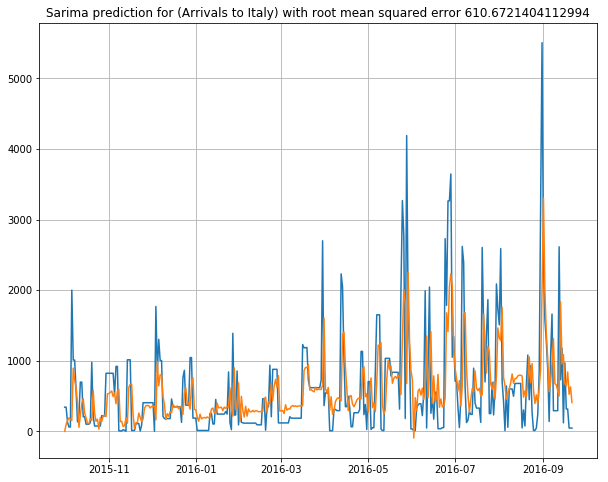

In [16]:
plt.figure(figsize=(10,8))
plt.plot(df_to_test)
plt.plot(predictions)
plt.grid()
error = measure_rmse(df_to_test, predictions)
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

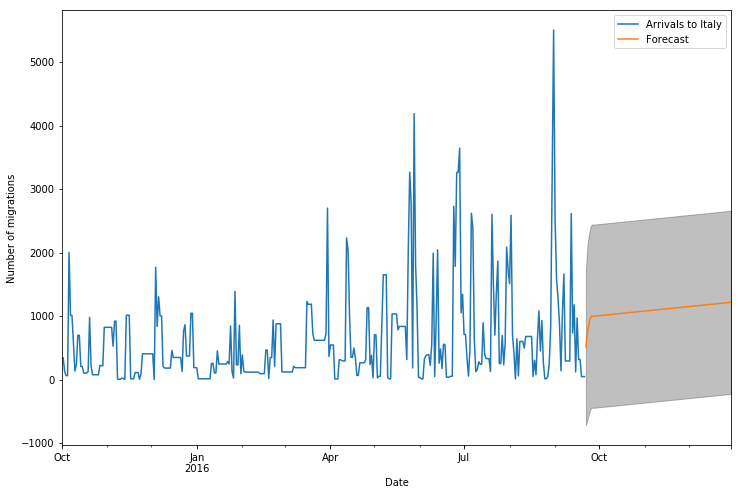

In [63]:
# Get forecast 100 steps ahead in future
pred_uc = result.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = df_to_test.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number of migrations')

plt.legend()
plt.show()